## Machine specific data

In [1]:
PSIS_DIRECTORY = '../../assignments'
DATA_PATH = '../../bepipred3.json'

## Imports

In [2]:
import json
import numpy as np
import pystan
import matplotlib.pyplot as plt
from scipy.special import logit, expit
import sys
from math import log
from collections import Counter

sys.path.append(PSIS_DIRECTORY)
import psis

## Load data

In [3]:
with open(DATA_PATH) as file:
    data = json.load(file)

In [4]:
# Check that all data has the same amino acids, predictions and labels
for protein in data:
    assert len(protein['epitope']) == len(protein['preds']) == len(protein['seq'])

In [5]:
# Remove X from protein
for protein in data:
    if 'X' in protein['seq']:
        x_positions = [i for i,n in enumerate(protein['seq']) if n == 'X']
        for k, v in protein.items():
            if not hasattr(v, "__len__") or len(v) != len(protein['seq']):
                continue
            newdata = [x for i,x in enumerate(v) if i not in x_positions]
            if isinstance(v, str):
                newdata = ''.join(newdata)
            protein[k] = newdata

In [6]:
# Add in features
n_aa = sum(len(protein['seq']) for protein in data)

aa_set = set()
for protein in data:
    aa_set.update(set(protein['seq']))
aa_index = {aa:i+1 for i,aa in enumerate(aa_set)} # Stan is 1-indexed


epitopes = np.empty(n_aa, dtype=np.int32)
scores = np.empty(n_aa, dtype=np.float32)
aa = np.empty(n_aa, dtype=np.int32)
inv_score_sum = np.empty(n_aa, dtype=np.float32)
inv_length = np.empty(n_aa, dtype=np.float32)

i = 0
for protein in data:
    length = len(protein['seq'])
    sum_scores = sum(protein['preds'])
    
    epitopes[i:i+length] = protein['epitope']
    scores[i:i+length] = protein['preds']
    aa[i:i+length] = [aa_index[i] for i in protein['seq']]
    inv_score_sum[i:i+length] = 1/sum_scores
    inv_length[i:i+length] = 1/length
    
    i += length
    
standata = {'n_aa': n_aa,
            'n_classes': len(aa_index),
            'epitopes': epitopes,
            'scores': scores,
            'aa': aa,
            'inv_score_sum': inv_score_sum,
            'inv_length': inv_length}

In [7]:
#standata = {'n_aa': 640,
#            'n_classes': len(np.unique(aa[:640])),
#            'epitopes': epitopes[:640],
#            'scores': scores[:640],
#            'aa': aa[:640],
#            'inv_score_sum': inv_score_sum[:640],
#            'inv_length': inv_length[:640]}

## Null model

In [8]:
n_epitopes = sum(standata['epitopes'])
logps = np.array([log(1 - n_epitopes / standata['n_aa']), log(n_epitopes / standata['n_aa'])])
model_null_loglik = logps[standata['epitopes']].sum()
model_null_loglik

-13544.838853581237

## Model 0:

Interpret BepiPred output as probabilities

In [9]:
model_0_loglik = np.empty((1, len(standata['scores'])), dtype=np.float32)
mask = standata['epitopes'] == 1
model_0_loglik[0, mask] = np.log(standata['scores'][mask])
model_0_loglik[0, ~mask] = np.log(1 - standata['scores'][~mask])

# No sampling, so we use the loglikelihood
model_0_loglik.sum()

-12883.652

## Model 1:

Epitope status calculated as logistic regression of prediction:

$ep = logit^{-1}(\alpha + \beta * pred)$

In [10]:
with open('models/pooled.stan') as f:
    model_1_code = f.read()

In [11]:
model_1 = pystan.StanModel(model_code=model_1_code, model_name='Model_1')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL Model_1_16473ccc58d6ccdd3f35e7f8c8a0e157 NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmpqisna0y0/stanfit4Model_1_16473ccc58d6ccdd3f35e7f8c8a0e157_6528605010157685952.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [12]:
fit_model_1 = model_1.sampling(data=standata)
print(fit_model_1)

Inference for Stan model: Model_1_16473ccc58d6ccdd3f35e7f8c8a0e157.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  -3.58  1.4e-3   0.04  -3.66   -3.6  -3.58  -3.55   -3.5    901    1.0
beta   12.62    0.01   0.38  11.86  12.36  12.63  12.88  13.36    922    1.0
lp__  -1.3e4    0.03   1.01 -1.3e4 -1.3e4 -1.3e4 -1.3e4 -1.3e4   1380    1.0

Samples were drawn using NUTS at Sat May 11 18:53:11 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


In [13]:
# Save data
extract_1 = fit_model_1.extract()
np.savez_compressed('cache/model_1.npz', **extract_1, **fit_model_1.summary())

In [401]:
# Calculate PSIS LOO
n_obs = len(extract_1['alpha'])
model_1_loglik = np.empty((n_obs, standata['n_aa']), dtype=np.float32)
mask = standata['epitopes'] == 1
for i in range(n_obs):
    alpha = extract_1['alpha'][i]
    beta = extract_1['beta'][i]
    ps = expit(alpha + beta * standata['scores'])
    ps[~mask] = 1-ps[~mask]
    model_1_loglik[i] = np.log(ps)

In [15]:
model_1_loo, model_1_loos, model_1_ks = psis.psisloo(model_1_loglik)
print(model_1_loos)

-12992.174


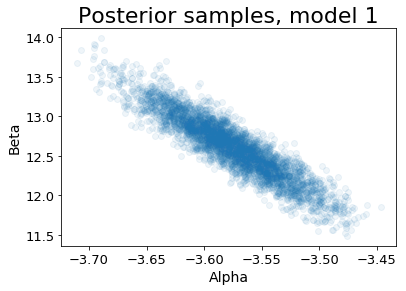

In [397]:
plt.plot(extract_1['alpha'], extract_1['beta'], 'o', alpha=0.07)
setplot('Posterior samples, model 1', "Alpha", "Beta")

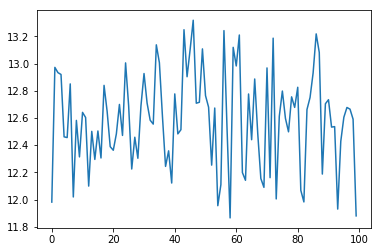

In [183]:
plt.plot(extract_1['beta'][:100])

In [111]:
psis.psisloo?

## Model 2

Hierarchical model distributing over the 20 amino acids: B[aa] ~N(m, s); p ~ expit(B[aa] + a*preds)

In [16]:
with open('models/hierarchical.stan') as file:
    model_2_code = file.read()

In [17]:
model_2 = pystan.StanModel(model_code=model_2_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9beacc40e8e5857606d3cea102b2c607 NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmp8dnzu5d3/stanfit4anon_model_9beacc40e8e5857606d3cea102b2c607_6839415377025437370.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [304]:
fit_model_2_bad = model_2.sampling(data=standata)
print(fit_model_2)

Inference for Stan model: anon_model_9beacc40e8e5857606d3cea102b2c607.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha_mu     -3.57  1.9e-3   0.05  -3.66   -3.6  -3.57  -3.53  -3.47    622   1.01
alpha_sigma   0.09  9.2e-4   0.03   0.04   0.07   0.09   0.11   0.16   1007    1.0
beta         12.55    0.02    0.4  11.74  12.28  12.54  12.82  13.32    602    1.0
alpha[1]     -3.58  2.2e-3   0.07  -3.71  -3.62  -3.58  -3.53  -3.44    956    1.0
alpha[2]     -3.46  2.4e-3   0.08   -3.6  -3.51  -3.46  -3.41  -3.31    946    1.0
alpha[3]     -3.52  2.0e-3   0.07  -3.66  -3.58  -3.53  -3.47  -3.37   1448    1.0
alpha[4]     -3.57  2.1e-3   0.09  -3.74  -3.63  -3.57  -3.52   -3.4   1667    1.0
alpha[5]     -3.61  2.1e-3   0.07  -3.75  -3.66  -3.61  -3.56  -3.47   1176    1.0
alpha[6]     -3.51  2.2e-3   0.07  -3.65  -3.56  -3.51  -3.46  -

In [305]:
# Save data
extract_2_bad = fit_model_2_bad.extract()
#np.savez_compressed('cache/model_2.npz', **extract_2, **fit_model_2.summary())

In [234]:
# Calculate PSIS LOO
n_obs = len(extract_2['alpha'])
model_2_loglik = np.empty((n_obs, standata['n_aa']), dtype=np.float32)
mask = standata['epitopes'] == 1
for i in range(n_obs):
    alpha = extract_2['alpha'][i][standata['aa'] - 1]
    beta = extract_2['beta'][i]
    ps = expit(alpha + beta*standata['scores'])
    ps[~mask] = 1-ps[~mask]
    model_2_loglik[i] = np.log(ps)

In [235]:
model_2_loo, model_2_loos, model_2_ks = psis.psisloo(model_2_loglik)
print(model_2_loo)

-12986.324


## Model 3

separate model

In [22]:
with open("models/separate.stan") as file:
    model_3_code = file.read()

In [23]:
model_3 = pystan.StanModel(model_code=model_3_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_083d69cdabb3d73c3eacf2102b1b65d3 NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmpx8o7gz8h/stanfit4anon_model_083d69cdabb3d73c3eacf2102b1b65d3_7535739011234899339.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [24]:
fit_model_3 = model_3.sampling(data=standata)
print(fit_model_3)

Inference for Stan model: anon_model_083d69cdabb3d73c3eacf2102b1b65d3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]   -2.96  2.2e-3   0.17  -3.31  -3.08  -2.96  -2.85  -2.63   6256    1.0
alpha[2]   -3.02  2.5e-3    0.2  -3.41  -3.15  -3.02  -2.89  -2.63   6579    1.0
alpha[3]   -3.77  2.4e-3    0.2  -4.18  -3.91  -3.77  -3.63  -3.38   6950    1.0
alpha[4]   -3.88  3.5e-3    0.3  -4.49  -4.08  -3.87  -3.68  -3.33   7176    1.0
alpha[5]   -3.42  2.8e-3   0.22  -3.85  -3.56  -3.41  -3.27  -2.99   6024    1.0
alpha[6]   -3.16  2.6e-3   0.21  -3.59   -3.3  -3.16  -3.01  -2.75   6692    1.0
alpha[7]   -3.42  2.9e-3   0.21  -3.83  -3.56  -3.41  -3.28  -3.01   5524    1.0
alpha[8]   -3.85  2.4e-3   0.18  -4.22  -3.97  -3.85  -3.72   -3.5   5717    1.0
alpha[9]   -3.38  2.5e-3    0.2  -3.79  -3.52  -3.38  -3.25  -3.01   6412    1.0
a

In [25]:
# Save data
extract_3 = fit_model_3.extract()
np.savez_compressed('cache/model_3.npz', **extract_3, **fit_model_3.summary())

In [26]:
# Calculate PSIS LOO
n_obs = len(extract_3['alpha'])
model_3_loglik = np.empty((n_obs, standata['n_aa']), dtype=np.float32)
mask = standata['epitopes'] == 1
for i in range(n_obs):
    alpha = extract_3['alpha'][i][standata['aa'] - 1]
    beta = extract_3['beta'][i][standata['aa'] - 1]
    ps = expit(alpha + beta*standata['scores'])
    ps[~mask] = 1-ps[~mask]
    model_3_loglik[i] = np.log(ps)

In [27]:
model_3_loo, model_3_loos, model_3_ks = psis.psisloo(model_3_loglik)
print(model_3_loo)

-12977.685


## Model 4

p ~ expit(a + b*pred + c/length * pred)

In [28]:
with open("models/length.stan") as file:
    model_4_code = file.read()

In [29]:
model_4 = pystan.StanModel(model_code=model_4_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e6d7604dde986c5d3c860dc5a5f6467a NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmpypklzupm/stanfit4anon_model_e6d7604dde986c5d3c860dc5a5f6467a_6347999825335297106.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [249]:
fit_model_4 = model_4.sampling(data=standata, control=dict(adapt_delta=0.9))
print(fit_model_4)

Inference for Stan model: anon_model_e6d7604dde986c5d3c860dc5a5f6467a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha_mu     -4.11  2.2e-3   0.06  -4.23  -4.15  -4.11  -4.07   -4.0    701    1.0
alpha_sigma   0.14  7.8e-4   0.04   0.08   0.11   0.13   0.16   0.22   2127    1.0
beta          9.73    0.01   0.43   8.89   9.45   9.73  10.02  10.58    906    1.0
alpha[1]     -4.09  2.4e-3   0.08  -4.24  -4.14  -4.09  -4.04  -3.94   1046    1.0
alpha[2]     -3.91  2.5e-3   0.08  -4.08  -3.97  -3.91  -3.86  -3.75   1071    1.0
alpha[3]     -4.06  2.0e-3   0.09  -4.23  -4.12  -4.06   -4.0  -3.89   1761    1.0
alpha[4]     -4.16  2.1e-3    0.1  -4.37  -4.23  -4.16  -4.09  -3.96   2443    1.0
alpha[5]      -4.1  2.3e-3   0.08  -4.26  -4.15   -4.1  -4.05  -3.95   1233    1.0
alpha[6]     -4.01  2.4e-3   0.08  -4.18  -4.07  -4.01  -3.96  -

In [250]:
# Save data
extract_4 = fit_model_4.extract()
np.savez_compressed('cache/model_4.npz', **extract_4, **fit_model_4.summary())

In [251]:
# Calculate PSIS LOO
n_obs = len(extract_4['gamma'])
model_4_loglik = np.empty((n_obs, standata['n_aa']), dtype=np.float32)
mask = standata['epitopes'] == 1
for i in range(n_obs):
    beta = extract_4['beta'][i]
    alpha = extract_4['alpha'][i][standata['aa'] - 1]
    gamma = extract_4['gamma'][i]
    ps = expit(alpha + beta*standata['scores'] + gamma*standata['inv_length'])
    ps[~mask] = 1-ps[~mask]
    model_4_loglik[i] = np.log(ps)

In [252]:
model_4_loo, model_4_loos, model_4_ks = psis.psisloo(model_4_loglik)
print(model_4_loo)

-12578.049


## Model 5

p ~ expit(a + b*pred + c/score * pred)

In [34]:
with open("models/scores.stan") as file:
    model_5_code = file.read()

In [35]:
model_5 = pystan.StanModel(model_code=model_5_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_490012f8c1fdc2841978a4954bfdc2cc NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmpnemgrmd2/stanfit4anon_model_490012f8c1fdc2841978a4954bfdc2cc_8321893021061570863.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [253]:
fit_model_5 = model_5.sampling(data=standata, control=dict(adapt_delta=0.9))
print(fit_model_5)

Inference for Stan model: anon_model_490012f8c1fdc2841978a4954bfdc2cc.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha_mu     -4.46  2.8e-3   0.06  -4.59   -4.5  -4.46  -4.42  -4.33    555    1.0
alpha_sigma   0.13  8.1e-4   0.03   0.07    0.1   0.12   0.15    0.2   1764    1.0
beta         10.55    0.01   0.42   9.74  10.27  10.55  10.83  11.37    902    1.0
alpha[1]     -4.45  2.9e-3   0.08  -4.61   -4.5  -4.45  -4.39  -4.28    815    1.0
alpha[2]     -4.29  3.0e-3   0.09  -4.46  -4.35  -4.29  -4.23  -4.12    820    1.0
alpha[3]     -4.41  2.7e-3   0.09  -4.58  -4.47  -4.41  -4.34  -4.23   1144    1.0
alpha[4]      -4.5  3.0e-3   0.11  -4.73  -4.58   -4.5  -4.43  -4.29   1350    1.0
alpha[5]     -4.45  2.8e-3   0.08  -4.62  -4.51  -4.45   -4.4  -4.28    903    1.0
alpha[6]     -4.38  3.0e-3   0.09  -4.56  -4.44  -4.38  -4.32  -

In [254]:
# Save data
extract_5 = fit_model_5.extract()
np.savez_compressed('cache/model_5.npz', **extract_5, **fit_model_5.summary())

In [255]:
# Calculate PSIS LOO
n_obs = len(extract_5['gamma'])
model_5_loglik = np.empty((n_obs, standata['n_aa']), dtype=np.float32)
mask = standata['epitopes'] == 1
for i in range(n_obs):
    beta = extract_5['beta'][i]
    alpha = extract_5['alpha'][i][standata['aa'] - 1]
    gamma = extract_5['gamma'][i]
    ps = expit(alpha + beta * standata['scores'] + gamma*standata['inv_score_sum'])
    ps[~mask] = 1-ps[~mask]
    model_5_loglik[i] = np.log(ps)

In [256]:
model_5_loo, model_5_loos, model_5_ks = psis.psisloo(model_5_loglik)
model_5_loo

-12546.508

## Model 6
Same as model 5, but with a separate instead of pooled model

In [40]:
with open("models/separate_scoresum.stan") as file:
    model_6_code = file.read()

In [41]:
model_6 = pystan.StanModel(model_code=model_6_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ccf4d7a0d4c0c635667dfef7910aeb6e NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmpwhez_ifa/stanfit4anon_model_ccf4d7a0d4c0c635667dfef7910aeb6e_6728712624795644153.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [42]:
fit_model_6 = model_6.sampling(data=standata)
print(fit_model_6)

Inference for Stan model: anon_model_ccf4d7a0d4c0c635667dfef7910aeb6e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]   -3.91  2.5e-3   0.18  -4.28  -4.03  -3.91  -3.79  -3.56   5296    1.0
alpha[2]   -3.85  2.7e-3   0.19  -4.22  -3.98  -3.85  -3.72  -3.49   5218    1.0
alpha[3]   -4.59  2.7e-3    0.2  -4.99  -4.73  -4.58  -4.44   -4.2   5796    1.0
alpha[4]    -4.9  3.7e-3    0.3  -5.52   -5.1  -4.89   -4.7  -4.33   6492    1.0
alpha[5]   -4.19  2.7e-3   0.22  -4.63  -4.34  -4.19  -4.05  -3.79   6549    1.0
alpha[6]   -4.03  2.8e-3   0.22  -4.46  -4.17  -4.03  -3.89  -3.59   5955    1.0
alpha[7]   -4.32  2.4e-3   0.22  -4.75  -4.46  -4.32  -4.17  -3.89   8335    1.0
alpha[8]   -4.74  2.3e-3   0.18  -5.09  -4.86  -4.74  -4.61  -4.39   5900    1.0
alpha[9]   -4.24  2.2e-3    0.2  -4.65  -4.37  -4.23   -4.1  -3.87   8038    1.0
a

In [43]:
# Save data
extract_6 = fit_model_6.extract()
np.savez_compressed('cache/model_6.npz', **extract_6, **fit_model_6.summary())

In [44]:
# Calculate PSIS LOO
n_obs = len(extract_6['gamma'])
model_6_loglik = np.empty((n_obs, standata['n_aa']), dtype=np.float32)
mask = standata['epitopes'] == 1
for i in range(n_obs):
    beta = extract_6['beta'][i][standata['aa'] - 1]
    alpha = extract_6['alpha'][i][standata['aa'] - 1]
    gamma = extract_6['gamma'][i]
    ps = expit(alpha + beta*standata['scores'] + gamma*standata['inv_score_sum'])
    ps[~mask] = 1-ps[~mask]
    model_6_loglik[i] = np.log(ps)

In [45]:
model_6_loo, model_6_loos, model_6_ks = psis.psisloo(model_6_loglik)
model_6_loo

-12537.997

## Model 7

In [421]:
with open("models/linear.stan") as file:
    model_7_code = file.read()

In [423]:
model_7 = pystan.StanModel(model_code=model_7_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e52c19e55a7805f4a3b1270ae410bd62 NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmpz4w7fvhv/stanfit4anon_model_e52c19e55a7805f4a3b1270ae410bd62_7875992498249936857.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [424]:
fit_model_7 = model_7.sampling(data=standata)
print(fit_model_7)

Inference for Stan model: anon_model_e52c19e55a7805f4a3b1270ae410bd62.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]   -3.14  1.4e-3   0.07  -3.27  -3.19  -3.14  -3.09  -3.01   2570    1.0
alpha[2]   -2.91  1.3e-3   0.07  -3.05  -2.95  -2.91  -2.86  -2.77   3112    1.0
alpha[3]   -3.44  1.4e-3   0.09  -3.62   -3.5  -3.44  -3.38  -3.27   3827    1.0
alpha[4]   -3.71  2.1e-3   0.15  -4.02  -3.81  -3.71  -3.61  -3.44   4925    1.0
alpha[5]    -3.2  1.4e-3   0.08  -3.35  -3.25   -3.2  -3.15  -3.05   2982    1.0
alpha[6]   -3.09  1.5e-3   0.08  -3.25  -3.14  -3.09  -3.03  -2.93   2934    1.0
alpha[7]   -3.23  1.5e-3   0.07  -3.37  -3.28  -3.23  -3.18  -3.09   2447    1.0
alpha[8]   -3.58  1.6e-3   0.08  -3.75  -3.63  -3.57  -3.52  -3.42   2897    1.0
alpha[9]   -3.21  1.5e-3   0.07  -3.36  -3.26  -3.21  -3.16  -3.06   2505    1.0
a

In [425]:
# Save data
extract_7 = fit_model_7.extract()
np.savez_compressed('cache/model_7.npz', **extract_7, **fit_model_7.summary())

In [428]:
# Calculate PSIS LOO
n_obs = len(extract_7['gamma'])
model_7_loglik = np.empty((n_obs, standata['n_aa']), dtype=np.float32)
mask = standata['epitopes'] == 1
for i in range(n_obs):
    alpha = extract_7['alpha'][i][standata['aa'] - 1]
    gamma = extract_7['gamma'][i]
    ps = expit(alpha + gamma * standata['inv_length'])
    ps[~mask] = 1-ps[~mask]
    model_7_loglik[i] = np.log(ps)

In [429]:
model_7_loo, model_7_loos, model_7_ks = psis.psisloo(model_7_loglik)
model_7_loo

-12813.068

## Model 8

In [331]:
with open("models/delme.stan") as file:
    model_8_code = file.read()

In [332]:
model_8 = pystan.StanModel(model_code=model_8_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_947035b09d6748b8242bdc945fae717c NOW.
/miniconda3/envs/stan/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/4j/9bxrl41n4fn8qvbk_crbzdq40000gp/T/tmpm3n5958e/stanfit4anon_model_947035b09d6748b8242bdc945fae717c_4076487123972986125.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [333]:
fit_model_8 = model_8.sampling(data=standata)
print(fit_model_8)

Inference for Stan model: anon_model_947035b09d6748b8242bdc945fae717c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
beta_mu     11.02    0.02   0.45   10.1  10.73  11.03  11.32  11.92    622    1.0
beta_sigma   0.76    0.01   0.29   0.27   0.56   0.74   0.94    1.4    551   1.01
beta[1]     10.63    0.02   0.53   9.55  10.28  10.64  11.01  11.62    998    1.0
beta[2]     11.76    0.02   0.59   10.6  11.36  11.76  12.14  12.93    869    1.0
beta[3]     11.49    0.02   0.74  10.12  11.01  11.45  11.97  13.04   1138    1.0
beta[4]     10.99    0.02    0.8   9.38  10.47   11.0   11.5  12.57   1500    1.0
beta[5]     10.81    0.02   0.57   9.67  10.43  10.83  11.19  11.88   1180    1.0
beta[6]     11.21    0.02   0.61  10.02  10.81   11.2   11.6  12.42   1137    1.0
beta[7]     11.15    0.02   0.61   9.94  10.75  11.15  11.56  12.36   114

In [334]:
extract_8 = fit_model_8.extract()

In [335]:
# Calculate PSIS LOO
n_obs = len(extract_8['gamma'])
model_8_loglik = np.empty((n_obs, standata['n_aa']), dtype=np.float32)
mask = standata['epitopes'] == 1
for i in range(n_obs):
    beta = extract_8['beta'][i][standata['aa'] - 1]
    alpha = extract_8['alpha'][i]
    gamma = extract_8['gamma'][i]
    ps = expit(alpha + beta * standata['scores'] + gamma*standata['inv_score_sum'])
    ps[~mask] = 1-ps[~mask]
    model_8_loglik[i] = np.log(ps)

In [336]:
model_8_loo, model_8_loos, model_8_ks = psis.psisloo(model_8_loglik)
model_8_loo

-12555.031

## Done models

In [52]:
def calc_peff(loglik, loo):
    likelihood = np.exp(loglik)
    observationwise_mean = likelihood.mean(axis=0)
    lppd = np.log(observationwise_mean).sum()
    return lppd - loo

In [53]:
plt.figure(figsize=(5, 5))
plt.plot(xs, ys)
setplot('ROC curve', 'False positive rate', 'True positive rate')
plt.axis([0, 1, 0, 1])
plt.plot([0,1], [0,1], 'k')

NameError: name 'xs' is not defined

<Figure size 360x360 with 0 Axes>

In [ ]:
asa = np.empty(n_aa, dtype=np.float32)
i = 0
for protein in data:
    asa[i:i+len(protein['asa'])] = protein['asa']
    i += len(protein['asa'])

In [ ]:
plt.figure(figsize=(8,5))
plt.boxplot([asa[mask], asa[~mask]]);
setplot('ASA of epitopes', 'Epitope?', 'ASA')
plt.xticks(range(1,3), ['Yes', 'No'])

In [64]:
def setplot(title, xlabel, ylabel):
    plt.title(title, fontsize=22)
    plt.tick_params(labelsize=13)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)

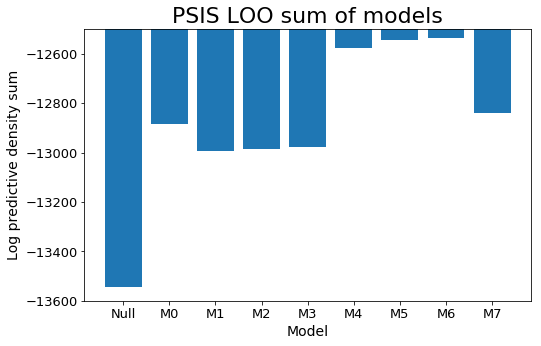

In [82]:
# psis_loo

loos = [model_null_loglik, model_0_loglik.sum(), model_1_loo, model_2_loo, model_3_loo, model_4_loo, model_5_loo, model_6_loo, model_7_loo]
plt.figure(figsize=(8, 5))
plt.bar(range(len(loos)), loos)
plt.ylim(-13600, -12500)
plt.xticks(range(len(loos)), ['Null'] + ['M'+str(i) for i in range(8)])
setplot('PSIS LOO sum of models', 'Model', 'Log predictive density sum')

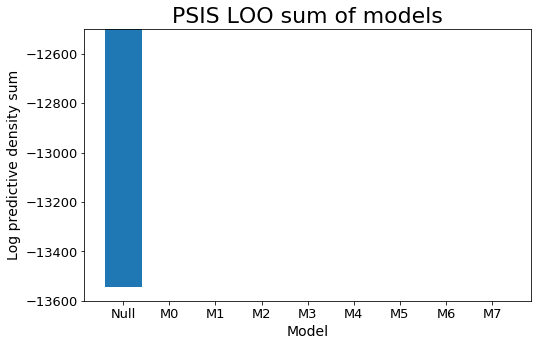

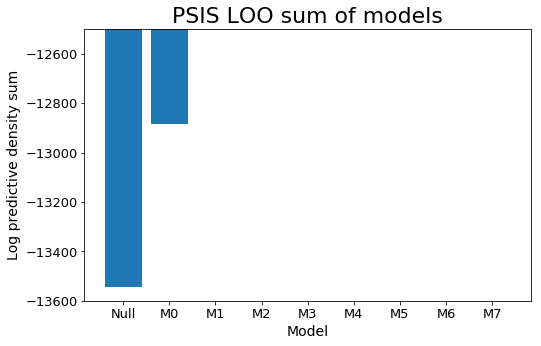

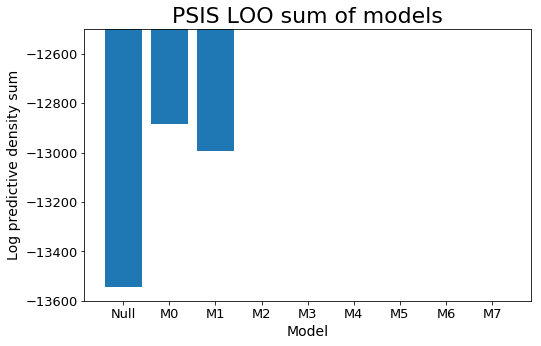

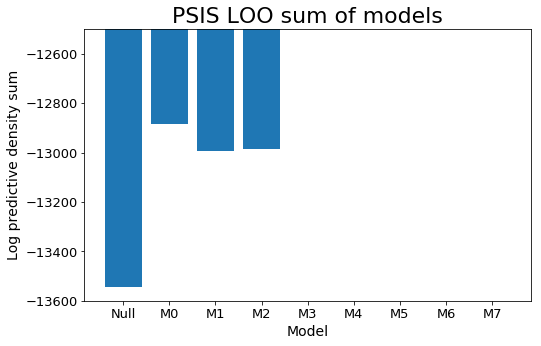

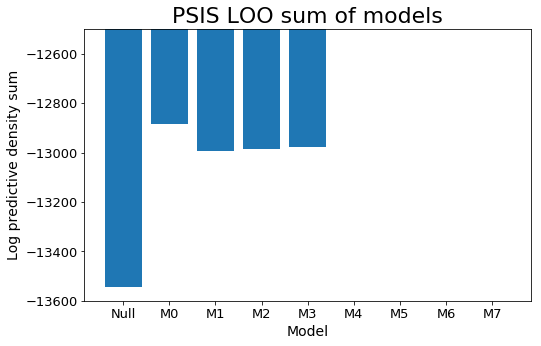

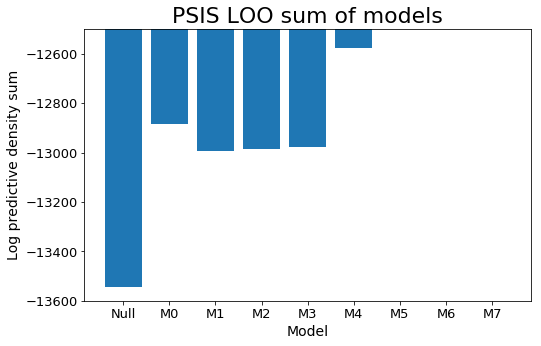

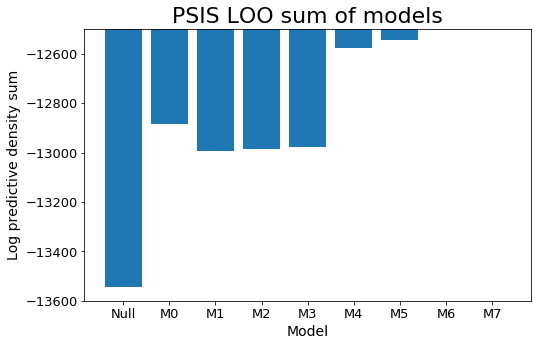

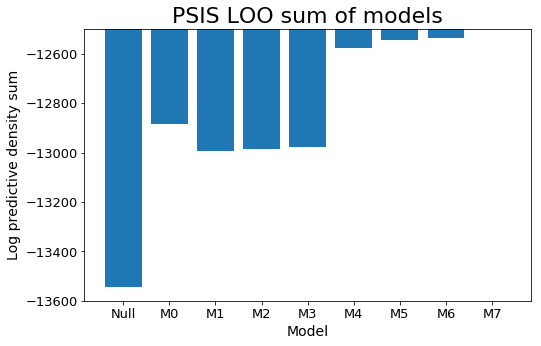

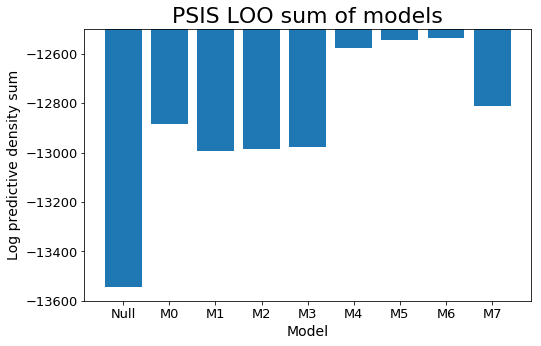

In [431]:
# psis_loo
loos = [model_null_loglik, model_0_loglik.sum(), model_1_loo, model_2_loo, model_3_loo, model_4_loo, model_5_loo, model_6_loo, model_7_loo]
for i in range(len(loos)):
    ys = loos[:i+1] + [0]*(len(loos)-i-1)
    plt.figure(figsize=(8, 5))
    plt.bar(range(len(loos)), ys)
    plt.ylim(-13600, -12500)
    plt.xticks(range(len(loos)), ['Null'] + ['M'+str(i) for i in range(9)])
    setplot('PSIS LOO sum of models', 'Model', 'Log predictive density sum')

In [86]:
def p_eff(lppd_loo_cv, log_like):
    """
    lppd_loo_cv: float
    log_like: (n x m) log-likelihood of m data points, given n posterior samples.
    """
    lppd = np.sum(np.log(np.mean(np.exp(log_like), axis=0)))
    return lppd - lppd_loo_cv

In [95]:
p_nominal = [0, 0, 2, 23, 40, 24, 24, 41, 21]

peffs = [0,
         0,
         p_eff(model_1_loo, model_1_loglik),
         p_eff(model_2_loo, model_2_loglik),
         p_eff(model_3_loo, model_3_loglik),
         p_eff(model_4_loo, model_4_loglik),
         p_eff(model_5_loo, model_5_loglik),
         p_eff(model_6_loo, model_6_loglik),
         p_eff(model_7_loo, model_7_loglik)
        ]

In [94]:
peffs

[0, 0, 1.84375, 13.352539, 36.833984, 16.5, 16.295898, 36.698242, 21.186523]

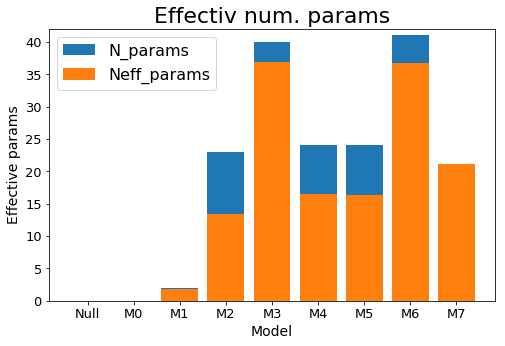

In [432]:
plt.figure(figsize=(8,5))
plt.bar(range(len(peffs)), p_nominal)
plt.bar(range(len(peffs)), peffs)

plt.ylim(0, 42)
plt.xticks(range(len(peffs)), ['Null'] + ['M'+str(i) for i in range(8)])
setplot('Effectiv num. params', 'Model', 'Effective params')
plt.legend(['N_params', 'Neff_params'], fontsize=16)

In [85]:
model_1_loglik

array([[-3.2384157 , -0.04376877, -3.2243297 , ..., -0.05105316,
        -0.05714292, -0.12216576],
       [-3.309352  , -0.04102345, -3.2940586 , ..., -0.04847459,
        -0.05477292, -0.12472036],
       [-3.3149016 , -0.04078079, -3.2996504 , ..., -0.04816501,
        -0.05440436, -0.12361146],
       ...,
       [-3.269629  , -0.04252387, -3.2550654 , ..., -0.04985549,
        -0.05601156, -0.12277492],
       [-3.2375343 , -0.04376965, -3.2235866 , ..., -0.0509772 ,
        -0.05699519, -0.12097061],
       [-3.2628045 , -0.04289729, -3.247962  , ..., -0.05044696,
        -0.05680206, -0.12632462]], dtype=float32)

(array([   19.,   498.,  2645.,  5878., 10578., 14948.,  9685.,  3266.,
          873.,    24.]),
 array([-0.31614331, -0.26628194, -0.21642058, -0.16655921, -0.11669784,
        -0.06683647, -0.0169751 ,  0.03288627,  0.08274764,  0.13260901,
         0.18247038]),
 <a list of 10 Patch objects>)

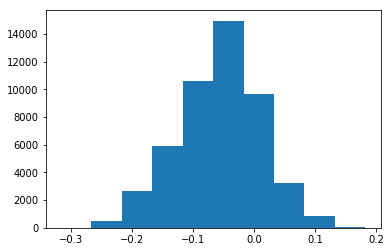

In [106]:
plt.hist(model_3_ks)

In [113]:
import psrf

In [213]:
psrf.psrf?

In [115]:
import stan_utility

In [178]:
stan_utility.check_div(fit_model_1)

0.0 of 4000 iterations ended with a divergence (0.0%)


In [177]:
stan_utility.check_energy?

In [142]:
len(xs)

160

In [144]:
len(y)

159

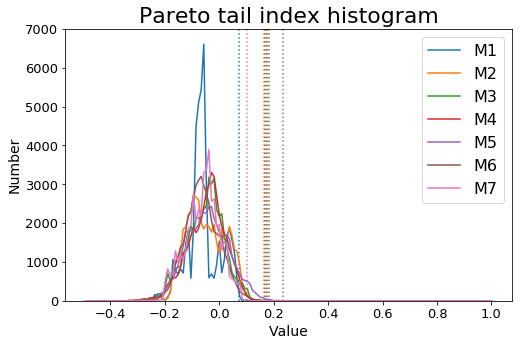

In [433]:
plt.figure(figsize=(8,5))
xs = np.linspace(-0.5, 1, 160)
for j, i in enumerate([eval("model_" + str(i) + "_ks") for i in range(1,8)]):
    y, x = np.histogram(i, xs)
    plt.plot(xs[1:], y)
    plt.vlines(max(i), 0, 7000, color='C'+str(j), linestyles='dotted')
setplot("Pareto tail index histogram", 'Value', 'Number')
plt.ylim(0, 7000)
plt.legend(['M' + str(i) for i in range(1,8)], fontsize=16)

In [172]:
plt.vlines?

In [164]:
plt.vlines?

In [157]:
[eval("model_" + str(i) + "_ks") for i in range(1,8)]

[array([-0.24318698, -0.08318952, -0.24369054, ..., -0.08813788,
        -0.06391807,  0.02237283]),
 array([-0.12258294, -0.05245045, -0.02391994, ...,  0.06419879,
        -0.17421505, -0.0742832 ]),
 array([ 0.05271897, -0.06144411, -0.02076474, ..., -0.07704367,
        -0.12129615, -0.03592725]),
 array([-0.01865541, -0.05101509, -0.08255368, ..., -0.09099901,
        -0.08833734, -0.13454636]),
 array([ 0.04218707, -0.02151781, -0.21747938, ..., -0.08219389,
        -0.18592442, -0.15459297]),
 array([ 0.12923898, -0.05730062,  0.10023378, ..., -0.11426705,
        -0.08369987, -0.08315055]),
 array([-0.15707779, -0.0418927 ,  0.12521783, ..., -0.08212059,
        -0.08337266, -0.09620395])]

In [155]:
eval("model_7_ks")

array([-0.15707779, -0.0418927 ,  0.12521783, ..., -0.08212059,
       -0.08337266, -0.09620395])

In [154]:
max(model_7_ks)

0.19259426072239874

In [140]:
y

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,   50,  165,  128,  161,   33,   20,  110,
        209, 1067,  772,  690,  819,  715, 1471, 1810,  583, 1899, 4508,
       5110, 5439, 6610, 2995,  593,  692,  581,  932, 1535,  724, 1047,
       1687, 1858, 1559, 1223,  519,  100,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [188]:
s = fit_model_3.summary()
s['summary'].shape

(41, 10)

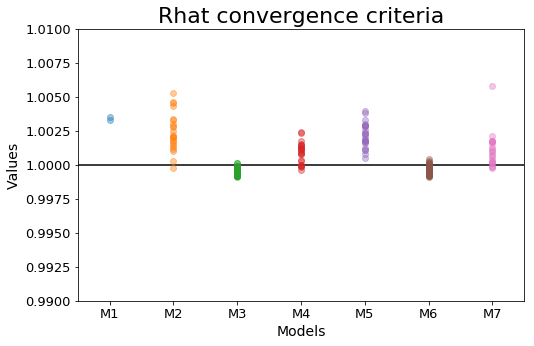

In [434]:
plt.figure(figsize=(8, 5))
plt.hlines(1, 0.5, 7.5)
for i in range(1, 8):
    ys = eval("fit_model_" + str(i)).summary()['summary'][:-1,9]
    plt.plot([i]*len(ys), ys, 'o', alpha=0.4)
plt.ylim(0.99, 1.01)
plt.xlim(0.5, 7.5)
setplot('Rhat convergence criteria', 'Models', 'Values')
plt.xticks(range(1, 8), ['M'+str(i) for i in range(1, 8)]);

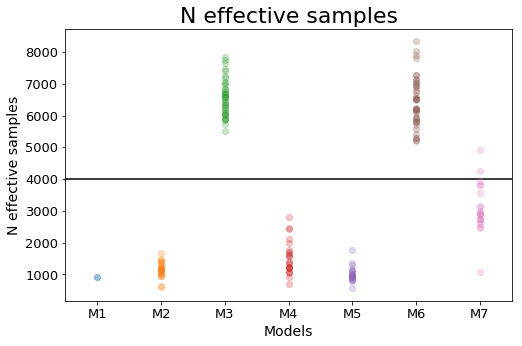

In [435]:
plt.figure(figsize=(8, 5))
plt.hlines(4000, 0.5, 7.5)
for i in range(1, 8):
    ys = eval("fit_model_" + str(i)).summary()['summary'][:-1,8]
    plt.plot([i]*len(ys), ys, 'o', alpha=0.25)
#plt.ylim(0.99, 1.01)
plt.xlim(0.5, 7.5)
setplot('N effective samples', 'Models', 'N effective samples')
plt.xticks(range(1, 8), ['M'+str(i) for i in range(1, 8)]);

In [258]:
for i in range(1, 8):
    fit = eval("fit_model_" + str(i))
    sampler_params = fit.get_sampler_params(inc_warmup=False)
    divergent = sum([x for y in sampler_params for x in y['divergent__']])
    print(divergent)

0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [306]:
sum([x for y in fit_model_2_bad.get_sampler_params(inc_warmup=False) for x in y['divergent__']])

5.0

[None, None]

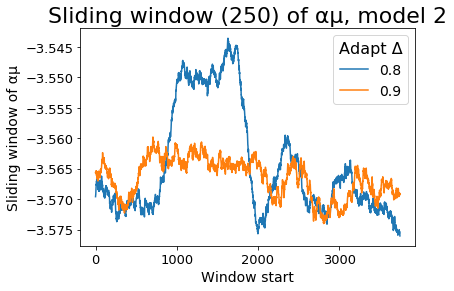

In [382]:
arr = extract_2_bad['alpha_mu']
w = 250
m = [arr[i:i+w].sum()/w for i in range(len(arr)-w)]
plt.plot(m)
arr = extract_2['alpha_mu']
m = [arr[i:i+w].sum()/w for i in range(len(arr)-w)]
plt.plot(m)
setplot('Sliding window (250) of αμ, model 2', 'Window start', 'Sliding window of αμ')
legend = plt.legend(["0.8", "0.9"], title='Adapt Δ', fontsize=14)
plt.setp(legend.get_title(), fontsize=16)

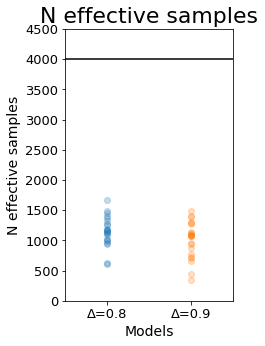

In [395]:
plt.figure(figsize=(3, 5))
plt.hlines(4000, 0.5, 7.5)
ys = fit_model_2.summary()['summary'][:-1,8]
plt.plot([1]*len(ys), ys, 'o', alpha=0.25)
ys = fit_model_2_bad.summary()['summary'][:-1,8]
plt.plot([2]*len(ys), ys, 'o', alpha=0.25)
plt.xlim(0.5, 2.5)
plt.ylim(0, 4500)
setplot('N effective samples', 'Models', 'N effective samples')
plt.xticks(range(1, 3), ['Δ=0.8', "Δ=0.9"]);

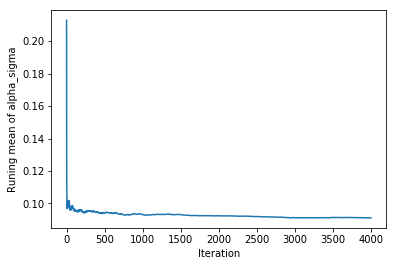

In [297]:
for m in (2,):
    running_mean = list()
    s = 0
    for i, v in enumerate(eval("extract_"+str(m))['alpha_sigma']):
        s += v
        running_mean.append(s / (i+1))
    plt.plot(running_mean)
    plt.ylabel('Runing mean of alpha_sigma')
    plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

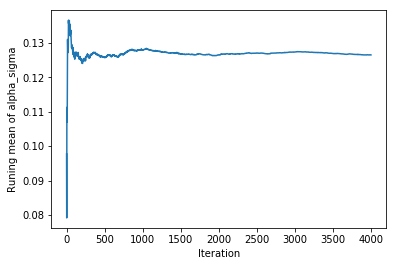

In [265]:
plt.plot(running_mean)
plt.ylabel('Runing mean of alpha_sigma')
plt.xlabel('Iteration')

Text(0.5, 0, 'Iteration')

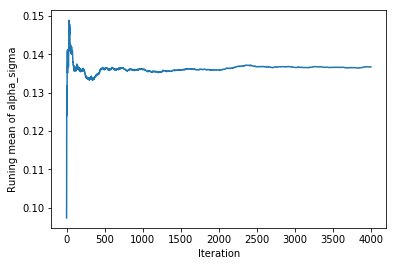

In [268]:
plt.plot(running_mean)
plt.ylabel('Runing mean of alpha_sigma')
plt.xlabel('Iteration')

In [226]:
stan_utility.check_div(fit_model_2)

10.0 of 4000 iterations ended with a divergence (0.25%)
Try running with larger adapt_delta to remove the divergences


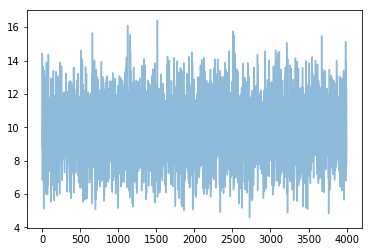

In [362]:
arr = extract_3['beta'][:,5]
plt.plot(arr, alpha=0.5)

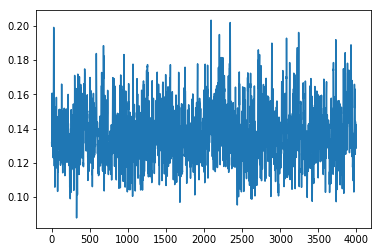

In [380]:
arr = extract_4['alpha_sigma']
w = 5
m = [arr[i:i+w].sum()/w for i in range(len(arr)-w)]
plt.plot(m)

In [354]:
extract_3['alpha'].shape

(4000, 20)

In [399]:
model_0_loglik.sum()

-12883.652

In [404]:
model_1_loglik.sum(axis=1).mean()

-12991.25

array([0.03707043, 0.04066976, 0.03762581, ..., 0.04766453, 0.05351477,
       0.11530049], dtype=float32)

In [414]:
p = expit(-3.58 + 12.62 * standata['scores'])
mask = standata['epitopes'] == 1
p[~mask] = 1 - p[~mask]
np.log(p).sum()

-12990.26

In [406]:
standata.keys()

dict_keys(['n_aa', 'n_classes', 'epitopes', 'scores', 'aa', 'inv_score_sum', 'inv_length'])

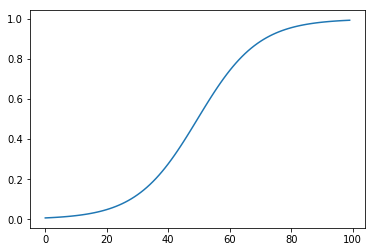

In [420]:
plt.plot(expit(np.linspace(-5, 5, 100)))

In [418]:
expit(2)

0.8807970779778823